# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


In [2]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [3]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [4]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [5]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

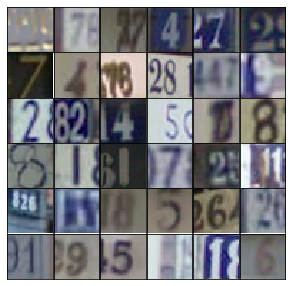

In [6]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. 
First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. 
We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [7]:
# Scale works the same as tanh
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [9]:
def model_inputs(real_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')    
    return inputs_real

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [10]:
def generator(x, output_dim, reuse=False, alpha=0.1, training=True, trainable=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(inputs=x, filters=64, kernel_size=5, strides=2, padding='same', trainable=trainable)
        # 16x16x64
        h2 = tf.layers.conv2d(inputs=h1, filters=128, kernel_size=5, strides=2, padding='same', trainable=trainable)
        # 8x8x128
        h3 = tf.layers.conv2d(inputs=h2, filters=256, kernel_size=5, strides=2, padding='same', trainable=trainable)
        # 4x4x256

        # Flatten it
        h3_vec = tf.reshape(h3, (-1, 4*4*256))
        h4 = tf.layers.dense(h3_vec, 4*4*512, trainable=trainable)
        z = tf.reshape(h4, (-1, 4, 4, 512))
        # 4x4x512 now
        
        h5 = tf.layers.conv2d_transpose(inputs=z, filters=256, kernel_size=5, strides=2, padding='same')
        bn5 = tf.layers.batch_normalization(h5, training=training)
        nl5 = tf.maximum(alpha * bn5, bn5)
        # 8x8x256 now
        
        h6 = tf.layers.conv2d_transpose(inputs=nl5, filters=128, kernel_size=5, strides=2, padding='same')
        bn6 = tf.layers.batch_normalization(h6, training=training)
        nl6 = tf.maximum(alpha * bn6, bn6)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(inputs=nl6, filters=output_dim, kernel_size=5, strides=2, padding='same')        
        predictions = tf.tanh(logits)
        # 32x32x3 now
        return predictions

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [11]:
def discriminator(x, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(inputs=x, filters=64, kernel_size=5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64
        
        h2 = tf.layers.conv2d(inputs=nl1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        h3 = tf.layers.conv2d(inputs=nl2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        nl3_vec = tf.reshape(nl3, (-1, 4*4*256))
        logits = tf.layers.dense(nl3_vec, 1)
        return logits

## Model Loss

Calculating the loss like before, nothing new here.

In [13]:
def model_loss(inputs_real, output_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param inputs_real: Images from the real dataset
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (generator loss, discriminators losses)
    """
    inputs_fake = generator(x=inputs_real, output_dim=output_dim, alpha=alpha)
    Q = discriminator(x=inputs_real, alpha=alpha)
    q = discriminator(x=inputs_fake, alpha=alpha, reuse=True)
    d_loss = tf.reduce_mean(Q-q)
    g_loss = -d_loss
    return g_loss, d_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [14]:
def model_opt(g_loss, d_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param g_loss: Generator loss Tensor: one
    :param d_loss: Discriminators' loss Tensors: multiple
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (generator training operation, discriminators training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
    return g_train_opt, d_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [15]:
class GAN:
    def __init__(self, real_size, learning_rate, alpha=0.2, beta1=0.5):
        self.input_real = model_inputs(real_dim=real_size)
        
        self.g_loss, self.d_loss = model_loss(inputs_real=self.input_real, output_dim=real_size[2], 
                                              alpha=alpha)
        
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, 
                                           learning_rate=learning_rate, beta1=beta1)

Here is a function for displaying generated images.

In [16]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [17]:
def train(net, dataset, epochs, batch_size, print_every=20, show_every=200, figsize=(5,5)):
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):

                # Run optimizers
                dloss, _ = sess.run([net.d_loss, net.d_opt], feed_dict={net.input_real: x})
                gloss, _ = sess.run([net.g_loss, net.g_opt], feed_dict={net.input_real: x})

                steps += 1
                if steps % print_every == 0:
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Dloss: {:.4f}".format(dloss),
                          "Gloss: {:.4f}".format(gloss))
                    # Save losses to view after training
                    losses.append((dloss, gloss))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(x=net.input_real, output_dim=3, reuse=True, training=False),
                                   feed_dict={net.input_real: x})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')
        with open('samples.pkl', 'wb') as f:
            pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [18]:
real_size = (32,32,3)
learning_rate = 0.0002
batch_size = 128
epochs = 100
alpha = 0.2
beta1 = 0.5

tf.reset_default_graph()

# Create the network
net = GAN(real_size=real_size, learning_rate=learning_rate, alpha=alpha, beta1=beta1)

dataset = Dataset(trainset, testset)

In [ ]:
losses, samples = train(net=net, dataset=dataset, epochs=epochs, batch_size=batch_size, figsize=(10,5))

Epoch 1/100... Dloss: -8.8428 Gloss: 16.3646
Epoch 1/100... Dloss: -18.4912 Gloss: 30.7080
Epoch 1/100... Dloss: -22.4215 Gloss: 32.7019
Epoch 1/100... Dloss: -32.2873 Gloss: 44.7084
Epoch 1/100... Dloss: -56.0625 Gloss: 65.1431


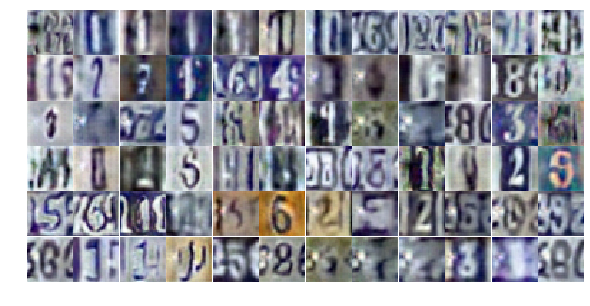
# Epoch 100/100... Dloss: -76723.1562 D2loss: -209684.1250 D3loss: -51635.3125 Gloss: 563816.3750
# Epoch 100/100... Dloss: -70481.7656 D2loss: -68062.9844 D3loss: -47298.8281 Gloss: 421534.7812

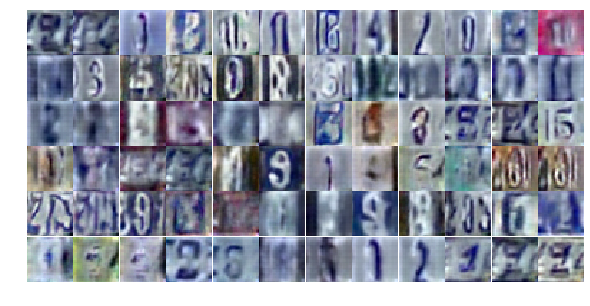
# Epoch 88/100... Dloss: -177498.5312 D2loss: -205811.8750 D3loss: -295007.9375 Gloss: 925749.2500
# Epoch 88/100... Dloss: -226103.6250 D2loss: -103767.3906 D3loss: -151497.3594 Gloss: 809055.3750

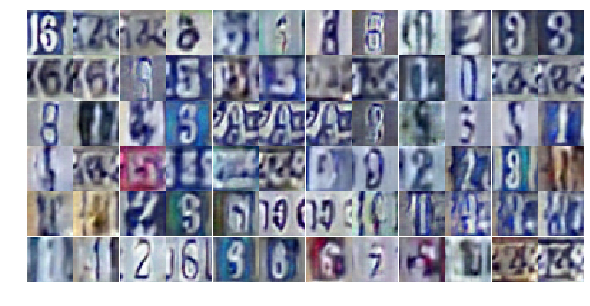
# Epoch 87/100... Dloss: -90999.9609 D2loss: -516778.6250 Gloss: 665492.5000
# Epoch 87/100... Dloss: -148741.9219 D2loss: -356826.5625 Gloss: 527256.6250

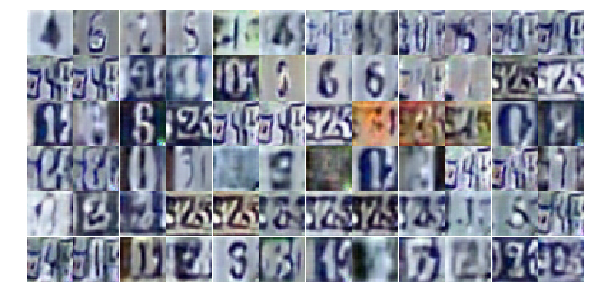
# poch 85/100... Dloss: -81643.2891 Gloss: 120432.2188
# Epoch 85/100... Dloss: -137074.6719 Gloss: 208558.0625

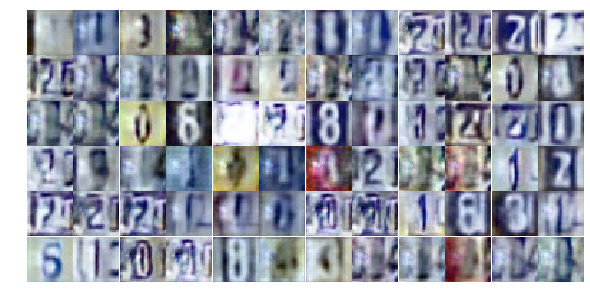

# Epoch 42/100... Dloss: -46476.2422 Gloss: 65515.3906
# Epoch 42/100... Dloss: -47235.1016 Gloss: 67322.2812

(2865, 3) (2865, 3) float32 float32


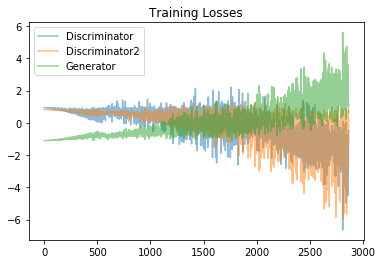

In [24]:
fig, ax = plt.subplots()
losses_ = np.array(losses)
losses_norm = (losses_ - losses_.mean(axis=0))/losses_.std(axis=0)
print(losses_.shape, losses_norm.shape, losses_norm.dtype, losses_norm.dtype)
plt.plot(losses_norm.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_norm.T[1], label='Discriminator2', alpha=0.5)
plt.plot(losses_norm.T[2], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

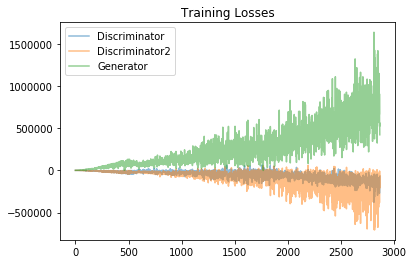

In [28]:
fig, ax = plt.subplots()
losses_ = np.array(losses)
plt.plot(losses_.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_.T[1], label='Discriminator2', alpha=0.5)
plt.plot(losses_.T[2], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

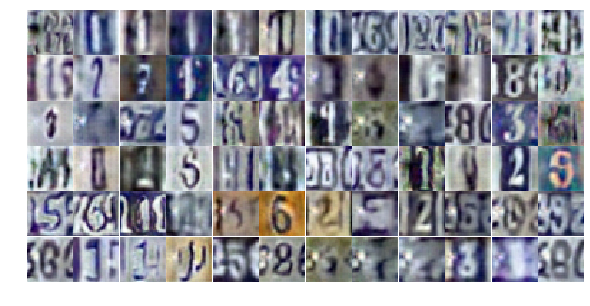

In [29]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

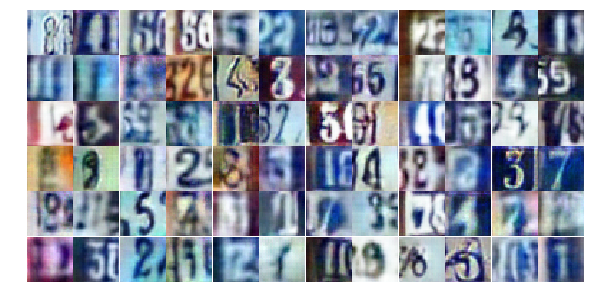

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))